=== (A) Evaluasi Regresi: Prediksi Suhu ===


,Metrik,Nilai
0,MSE,1.5844
1,R²,0.5915



Feature Importance (Regresi Suhu)


,Fitur,Importance
2,Kelembaban,0.790313
0,Angin,0.143409
3,Awan_encoded,0.066279
1,Curah_Hujan,0.000000


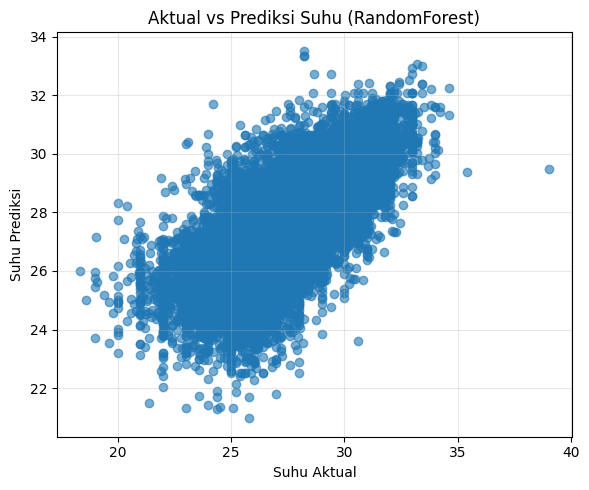


Insight Regresi


,Insight
0,Model RandomForest untuk Suhu menghasilkan R² ...
1,Kelembaban dan/atau Curah_Hujan biasanya domin...
2,Gunakan model ini untuk estimasi suhu jangka p...



Distribusi label Awan (asli):
Counter({20: 121508, 40: 66332, 75: 23799, 100: 7373, 99: 2999, 98: 1751, 97: 1411, 96: 1108, 90: 1047, 95: 921, 1: 795, 94: 786, 93: 769, 92: 674, 91: 642, 21: 558, 89: 547, 28: 543, 19: 531, 23: 527, 30: 521, 25: 520, 22: 519, 24: 518, 31: 516, 34: 514, 26: 510, 87: 499, 88: 497, 16: 493, 27: 488, 35: 481, 37: 476, 32: 476, 38: 472, 17: 471, 41: 470, 18: 469, 29: 467, 33: 459, 85: 449, 14: 439, 15: 439, 13: 431, 39: 426, 86: 426, 12: 425, 36: 419, 11: 414, 10: 409, 44: 405, 9: 402, 42: 392, 84: 391, 43: 391, 45: 382, 47: 377, 80: 370, 83: 365, 79: 364, 82: 360, 78: 358, 7: 356, 46: 355, 48: 350, 8: 348, 49: 347, 81: 345, 54: 337, 50: 333, 51: 327, 77: 314, 73: 312, 53: 310, 68: 304, 52: 303, 72: 301, 59: 299, 76: 298, 0: 298, 64: 294, 55: 293, 6: 293, 67: 290, 65: 283, 71: 278, 74: 277, 66: 277, 57: 277, 69: 277, 63: 277, 56: 276, 4: 276, 5: 274, 58: 272, 61: 272, 3: 267, 62: 266, 70: 262, 2: 259, 60: 256})

Distribusi label Awan (bucketed):
Counter({'C

In [ ]:
# =======================
# 03_Model_Clarification.ipynb (FINAL)
# =======================
import warnings
warnings.filterwarnings("ignore")  # suppress warning agar output bersih

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    classification_report, accuracy_score, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# ---------- Konfigurasi ----------
N_ROWS = None
DATA_PATH = "../data/cuaca_clean.csv"
RANDOM_STATE = 42

# ---------- Load ----------
df = pd.read_csv(DATA_PATH, nrows=N_ROWS)
required = ['Tanggal','Suhu','Curah_Hujan','Kelembaban','Angin','Awan']
assert set(required).issubset(df.columns), "Kolom wajib tidak lengkap."

df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')
for col in ['Suhu','Kelembaban','Curah_Hujan','Angin']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------- Handle minimal missing untuk modeling ----------
# Untuk regresi & klasifikasi, kita drop baris yang 'target'nya NaN
df_reg = df.copy()
df_clf = df.copy()

# =======================
# (A) REGRESI: Prediksi SUHU
# =======================
# Fitur: Angin, Curah_Hujan, Kelembaban, Awan (jika Awan object → encode)
reg_df = df_reg[['Angin','Curah_Hujan','Kelembaban','Awan','Suhu']].copy()

if reg_df['Awan'].dtype == 'object':
    le_reg = LabelEncoder()
    reg_df['Awan_encoded'] = le_reg.fit_transform(reg_df['Awan'].astype(str))
else:
    reg_df['Awan_encoded'] = reg_df['Awan']

# Imputasi simpel
for c in ['Angin','Curah_Hujan','Kelembaban','Awan_encoded','Suhu']:
    reg_df[c] = pd.to_numeric(reg_df[c], errors='coerce')
reg_df = reg_df.dropna(subset=['Suhu'])
reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']] = \
    reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']].fillna(reg_df.mean(numeric_only=True))

X_reg = reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']]
y_reg = reg_df['Suhu']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

regressor = RandomForestRegressor(
    n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)

mse = mean_squared_error(y_test_r, y_pred_r)
r2  = r2_score(y_test_r, y_pred_r)

eval_reg = pd.DataFrame({
    "Metrik": ["MSE", "R²"],
    "Nilai": [mse, r2]
})
print("=== (A) Evaluasi Regresi: Prediksi Suhu ===")
display(eval_reg.round(4))

# Feature importance (regresi)
fi_reg = pd.DataFrame({
    "Fitur": X_reg.columns,
    "Importance": regressor.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nFeature Importance (Regresi Suhu)")
display(fi_reg)

# Visual: scatter aktual vs prediksi
plt.figure(figsize=(6,5))
plt.scatter(y_test_r, y_pred_r, alpha=0.6)
plt.xlabel("Suhu Aktual")
plt.ylabel("Suhu Prediksi")
plt.title("Aktual vs Prediksi Suhu (RandomForest)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Insight Regresi
insight_reg = pd.DataFrame({
    "Insight": [
        f"Model RandomForest untuk Suhu menghasilkan R² = {r2:.2f} (semakin dekat 1, semakin baik).",
        "Kelembaban dan/atau Curah_Hujan biasanya dominan memengaruhi prediksi suhu (cek tabel importance).",
        "Gunakan model ini untuk estimasi suhu jangka pendek; untuk jangka panjang pertimbangkan fitur musiman."
    ]
})
print("\nInsight Regresi")
display(insight_reg)

# =======================
# (B) KLASIFIKASI: Prediksi Kategori AWAN
# =======================
# Dua skenario:
#  (B1) Multikelas dengan label asli (bisa sangat imbalanced)
#  (B2) Bucketing ke 4 kelas agar lebih seimbang & bermakna operasional
# ---------- KLASIFIKASI (Final Aman) ----------

clf_base = df_clf[['Angin','Curah_Hujan','Kelembaban','Suhu','Awan']].copy()

# Convert ke numeric
clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']] = \
    clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']].apply(pd.to_numeric, errors='coerce')

# Imputasi aman (daripada drop semua)
clf_base['Curah_Hujan'] = clf_base['Curah_Hujan'].fillna(0)  # hujan kosong → 0
clf_base['Angin']       = clf_base['Angin'].fillna(clf_base['Angin'].median())
clf_base['Kelembaban']  = clf_base['Kelembaban'].fillna(clf_base['Kelembaban'].median())
clf_base['Suhu']        = clf_base['Suhu'].fillna(clf_base['Suhu'].median())

# Drop baris tanpa label 'Awan' (harus ada target)
clf_base = clf_base.dropna(subset=['Awan'])

print("\nDistribusi label Awan (asli):")
print(Counter(clf_base['Awan']))

# Bucketing Awan
def bucket_awan(val):
    if pd.api.types.is_number(val):
        v = float(val)
        if v <= 20:   return "Cerah"
        elif v <= 45: return "Cerah Berawan"
        elif v <= 75: return "Mendung"
        else:         return "Hujan"
    else:
        return str(val)

clf_base['Awan_bucket'] = clf_base['Awan'].apply(bucket_awan)

print("\nDistribusi label Awan (bucketed):")
print(Counter(clf_base['Awan_bucket']))

X_clf = clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']]
y_clf_bucket = clf_base['Awan_bucket']

# Cek cukup data
if len(X_clf) < 5:
    raise ValueError(f"Dataset klasifikasi terlalu kecil ({len(X_clf)} sampel).")

# Split data → fallback aman kalau stratify gagal
try:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_clf, y_clf_bucket,
        test_size=0.2, random_state=RANDOM_STATE,
        stratify=y_clf_bucket if len(set(y_clf_bucket)) > 1 else None
    )
except ValueError as e:
    print("⚠️ Stratify gagal, fallback tanpa stratify:", e)
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_clf, y_clf_bucket, test_size=0.2, random_state=RANDOM_STATE
    )

classifier = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight='balanced_subsample',
    n_jobs=-1
)
classifier.fit(X_train_c, y_train_c)
y_pred_c = classifier.predict(X_test_c)

acc = accuracy_score(y_test_c, y_pred_c)
report = classification_report(y_test_c, y_pred_c, zero_division=0, output_dict=True)
eval_clf = pd.DataFrame(report).T

print("\n=== (B) Evaluasi Klasifikasi: Prediksi Awan (Bucket 4 kelas) ===")
print(f"Accuracy keseluruhan: {acc:.4f}")
display(eval_clf.round(3))

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_c, y_pred_c, labels=sorted(y_train_c.unique()))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y_train_c.unique()),
            yticklabels=sorted(y_train_c.unique()))
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Awan (Bucket 4 kelas)")
plt.tight_layout()
plt.show()

# Feature importance (klasifikasi)
fi_clf = pd.DataFrame({
    "Fitur": X_clf.columns,
    "Importance": classifier.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nFeature Importance (Klasifikasi Awan)")
display(fi_clf)

# Insight Klasifikasi
insight_clf = pd.DataFrame({
    "Insight": [
        f"Accuracy {acc:.2f}. Dengan bucketing 4 kelas, model lebih stabil daripada multi-kelas asli yang sangat imbalanced.",
        "Fitur yang paling memengaruhi kategori awan biasanya Suhu dan Kelembaban (cek importance).",
        "Jika tetap ingin pakai label asli (banyak kelas), pertimbangkan penggabungan kelas jarang atau oversampling (SMOTE)."
    ]
})
print("\nInsight Klasifikasi")
display(insight_clf)

# ---------- Deliverable tambahan ----------
# Simpan prediksi sampel (ringan) untuk dokumentasi (opsional)
out = X_test_c.copy()
out['Awan_Actual'] = y_test_c
out['Awan_Predicted'] = y_pred_c
display(out.head(10))
